# Trading Signal Generation

In [124]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.manifold import TSNE
import os

pd.set_option('display.max_colwidth', None)

## Preprocessing

In [125]:
file_path = "data/processed/labeled_january_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_jan = pd.read_csv(file)

In [126]:
file_path = "data/processed/labeled_february_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_feb = pd.read_csv(file)

In [127]:
file_path = "data/processed/labeled_march_data.csv"

with open(file_path, "r", encoding="utf-8") as file:
    df_march = pd.read_csv(file)

In [128]:
import re

def normalize_numbers(text):
    # Replace monetary values (e.g., "R$ 15 bilhões" → "15B")
    text = re.sub(r"R\$ ?([\d.,]+) bilhões", r"\1B", text)
    text = re.sub(r"R\$ ?([\d.,]+) milhões", r"\1M", text)
    # Standardize percentages (e.g., "0.5 pp" → "0.5%")
    text = re.sub(r"([\d.,]+) pp", r"\1%", text)
    # Standardize plain numbers (e.g., "15,000" → "15000")
    text = text.replace(",", "")
    return text

In [129]:
def remove_noise(text):
    # Remove dates and times
    text = re.sub(r"\b\d{1,2}[hH]\d{2}\b", "", text)  # Times like "17h20"
    text = re.sub(r"\b\d{1,2}ª[Ff]\b", "", text)       # Ordinals like "2ªF"
    # Remove redundant words
    text = re.sub(r"MAIS AGENDA|LÁ FORA|A BOLSA ESTÁ CARA", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [130]:
import re

# Comprehensive dictionary for expanding acronyms
acronyms = {
    "Selic": "Sistema Especial de Liquidação e de Custódia",
    "PIB": "Produto Interno Bruto",
    "CDI": "Certificado de Depósito Interbancário",
    "LPRs": "Loan Prime Rates",
    "Ibovespa": "Índice Bovespa",
    "BB": "Banco do Brasil",
    "BC": "Banco Central",
    "FGTS": "Fundo de Garantia do Tempo de Serviço",
    "STF": "Supremo Tribunal Federal",
    "CPI": "Índice de Preços ao Consumidor",
    "MP": "Medida Provisória",
    "EUA": "Estados Unidos",
    "ONU": "Organização das Nações Unidas",
    "FGV": "Fundação Getúlio Vargas",
    "IBGE": "Instituto Brasileiro de Geografia e Estatística",
    "BNDES": "Banco Nacional de Desenvolvimento Econômico e Social",
    "IPCA": "Índice Nacional de Preços ao Consumidor Amplo",
    "DI": "Depósito Interfinanceiro",
    "IR": "Imposto de Renda",
    "OI": "Operadora Oi",
    "CV": "Câmara de Vereadores"
}

noisy_acronyms = {"ROMI", "ENEVA", "LIGHT", "DA"}

def expand_acronyms(text, acronym_dict):
    for acronym, full_form in acronym_dict.items():
        text = re.sub(rf'\b{re.escape(acronym)}\b', full_form, text, flags=re.IGNORECASE)
    return text

def remove_noisy_acronyms(text, noisy_set):
    return re.sub(r'\b(?:' + '|'.join(noisy_set) + r')\b', '', text)

In [131]:
import spacy

# Load Portuguese spaCy model
nlp = spacy.load("pt_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

In [132]:
def preprocess_text(text):
    text = normalize_numbers(text)         
    text = expand_acronyms(text, acronyms)
    text = remove_noisy_acronyms(text, noisy_acronyms)
    text = lemmatize_text(text)          
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Apply preprocessing to the dataset
df_jan['preprocessed_article'] = df_jan['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_feb['preprocessed_article'] = df_feb['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)
df_march['preprocessed_article'] = df_march['article'].apply(
    lambda x: pd.Series(preprocess_text(x))
)

## Applying the Word2Vec approach

In [133]:
from gensim.models import Word2Vec

# Prepare tokenized articles
tokenized_articles = df_jan['preprocessed_article'].apply(str.split).tolist() + df_feb['preprocessed_article'].apply(str.split).tolist() 
# Train Word2Vec
word2vec_model = Word2Vec(
    sentences=tokenized_articles,
    vector_size=300,  # Embedding dimensionality
    window=5,         # Context window size
    min_count=2,      # Minimum word frequency
    sg=1,             # Skip-gram method
    workers=4,        # Number of threads
    epochs=30         # Number of training iterations
)

word2vec_model.save("models/w2v_embeddings_experiment_v1/w2v.model")

In [134]:
import numpy as np

def vectorize_article(text, model):
    """
    Generate a document vector by averaging word embeddings.
    :param text: Preprocessed article as a string.
    :param model: Trained Word2Vec model.
    :return: Document vector (numpy array).
    """
    tokens = text.split()
    word_vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Generate embeddings for both datasets
df_jan['embedding'] = df_jan['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))
df_feb['embedding'] = df_feb['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))
df_march['embedding'] = df_march['preprocessed_article'].apply(lambda x: vectorize_article(x, word2vec_model))

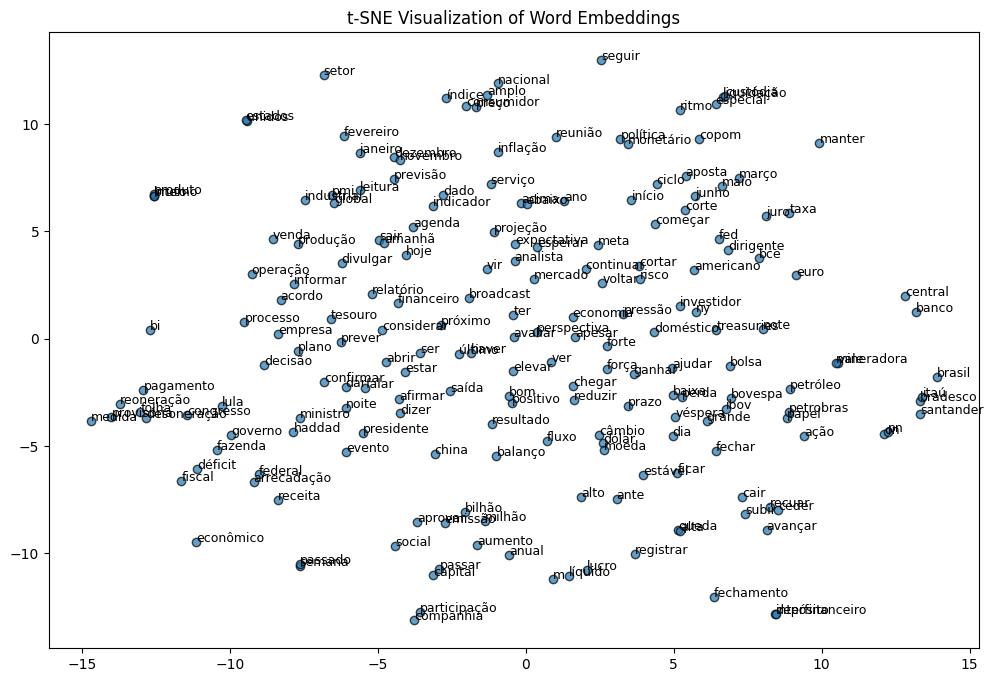

In [135]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Get most frequent words
most_frequent_words = word2vec_model.wv.index_to_key[:200]  # Top 200 words
word_vectors = np.array([word2vec_model.wv[word] for word in most_frequent_words])

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_embeddings_2d = tsne.fit_transform(word_vectors)

# Plot t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1], alpha=0.7, edgecolors='k')
for i, word in enumerate(most_frequent_words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]), fontsize=9)
plt.title('t-SNE Visualization of Word Embeddings')
plt.savefig("results/w2v_embeddings_experiment_v1/figures/word2vec_tsne_visualization.png")
plt.show()

## Visualising the distribution of the Target variable
- helps us to realize a class imbalance
- good to keep track of
- MOVE THIS INTO the PREPROCESSING file eventually

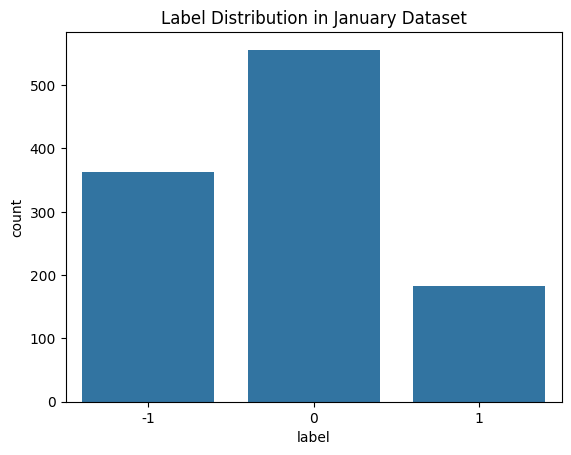

In [136]:
sns.countplot(x='label', data=df_jan)
plt.title('Label Distribution in January Dataset')
plt.savefig("results/w2v_embeddings_experiment_v1/figures/label_distribution_january.png")
plt.show()

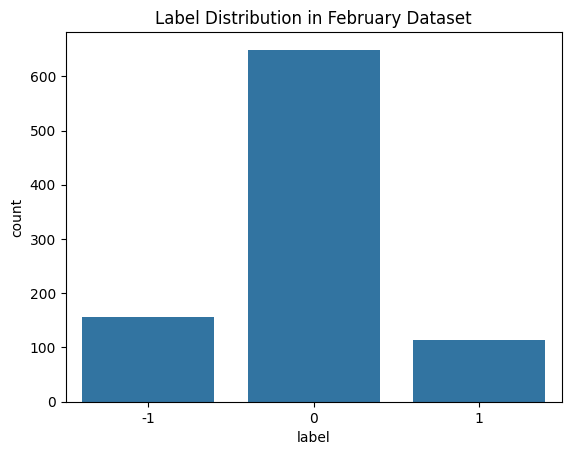

In [137]:
sns.countplot(x='label', data=df_feb)
plt.title('Label Distribution in February Dataset')
plt.savefig("results/w2v_embeddings_experiment_v1/figures/label_distribution_february.png")
plt.show()

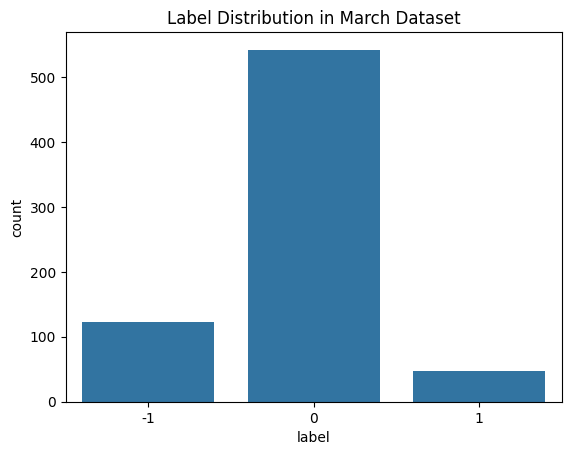

In [138]:
sns.countplot(x='label', data=df_march)
plt.title('Label Distribution in March Dataset')
plt.savefig("results/w2v_embeddings_experiment_v1/figures/label_distribution_march.png")
plt.show()

In [139]:
# Inspect class distribution
print("January class distribution:")
print(df_jan['label'].value_counts())

print("February class distribution:")
print(df_feb['label'].value_counts())

print("March class distribution (test set):")
print(df_march['label'].value_counts())

January class distribution:
label
 0    556
-1    363
 1    182
Name: count, dtype: int64
February class distribution:
label
 0    649
-1    157
 1    113
Name: count, dtype: int64
March class distribution (test set):
label
 0    542
-1    123
 1     48
Name: count, dtype: int64


In [140]:
from scipy.spatial.distance import pdist, squareform
import numpy as np
import pandas as pd

def calculate_intra_class_distance(df, class_label):
    
    class_vectors = np.vstack(df[df['label'] == class_label]['embedding'].values)
    if len(class_vectors) <= 1:
        return 0  

    pairwise_distances = pdist(class_vectors, metric='euclidean')
    return np.mean(pairwise_distances)

def calculate_inter_class_distance(df, label_1, label_2):

    vectors_1 = np.vstack(df[df['label'] == label_1]['embedding'].values)
    vectors_2 = np.vstack(df[df['label'] == label_2]['embedding'].values)

    pairwise_distances = np.linalg.norm(vectors_1[:, None] - vectors_2, axis=2).flatten()
    return np.mean(pairwise_distances)

labels = [-1, 0, 1]
intra_class_distances = {label: calculate_intra_class_distance(df_jan, label) for label in labels}

inter_class_distances = {}
for i, label_1 in enumerate(labels):
    for label_2 in labels[i + 1:]:
        key = f"{label_1} vs {label_2}"
        inter_class_distances[key] = calculate_inter_class_distance(df_jan, label_1, label_2)

print("Intra-Class Distances:")
for label, dist in intra_class_distances.items():
    print(f"Label {label}: {dist:.4f}")

print("\nInter-Class Distances:")
for pair, dist in inter_class_distances.items():
    print(f"{pair}: {dist:.4f}")

Intra-Class Distances:
Label -1: 1.9810
Label 0: 2.0196
Label 1: 2.0864

Inter-Class Distances:
-1 vs 0: 2.0341
-1 vs 1: 2.0381
0 vs 1: 2.0763


## Multinomial Logistic Regression Model with Custom Word2Vec Model

Task: 
- Train on January, test on February
    - Train / test with 3 classes (+1, 0, -1), yielding a 3 x 3 confusion matrix
    - Train / test with 2 classes (+1, -1), yielding a 2 x 2 confusion matrix

In [154]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from scipy.special import softmax
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
# multiclass classification
# combine df_jan and df_feb for training
X_train_multi = np.vstack(np.concatenate((df_jan['embedding'].values, df_feb['embedding'].values)))
y_train_multi = np.concatenate((df_jan['label'], df_feb['label']))
X_test_multi = np.vstack(df_march['embedding'].values)
y_test_multi = df_march['label']

# binary classification
# filter out rows where label is 0 for binary classification
df_train_binary = pd.concat([df_jan, df_feb])
df_train_binary = df_train_binary[df_train_binary['label'] != 0]
df_march_binary = df_march[df_march['label'] != 0]

X_train_binary = np.vstack(df_train_binary['embedding'].values)
y_train_binary = df_train_binary['label']
X_test_binary = np.vstack(df_march_binary['embedding'].values)
y_test_binary = df_march_binary['label']

In [158]:
# multinomial Logistic Regression (multi-class)
multi_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
multi_model.fit(X_train_multi, y_train_multi)
multi_preds = multi_model.predict(X_test_multi)

# binary Logistic regression (binary classification)
binary_model = LogisticRegression(max_iter=1000)
binary_model.fit(X_train_binary, y_train_binary)
binary_preds = binary_model.predict(X_test_binary)

c:\Users\scaro\Downloads\pt-br\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [159]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Directory to save results
save_dir = "results/w2v_embeddings_experiment_v1/metrics"
os.makedirs(save_dir, exist_ok=True)

# Evaluate multi-class model
multi_class_report = classification_report(y_test_multi, multi_preds)
multi_class_cm = confusion_matrix(y_test_multi, multi_preds)

# Save multi-class metrics
with open(os.path.join(save_dir, "classification_report_multi.txt"), "w") as f:
    f.write("Multi-class Classification Report:\n")
    f.write(multi_class_report)

# Save multi-class confusion matrix
multi_class_cm_file = os.path.join(save_dir, "confusion_matrix_multi.png")
sns.heatmap(multi_class_cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.title("Multi-class Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(multi_class_cm_file)
plt.close()

In [160]:
# Evaluate binary model
binary_class_report = classification_report(y_test_binary, binary_preds)
binary_class_cm = confusion_matrix(y_test_binary, binary_preds)

# Save binary metrics
with open(os.path.join(save_dir, "classification_report_binary.txt"), "w") as f:
    f.write("Binary Classification Report:\n")
    f.write(binary_class_report)

# Save binary confusion matrix
binary_class_cm_file = os.path.join(save_dir, "confusion_matrix_binary.png")
sns.heatmap(binary_class_cm, annot=True, fmt='d', cmap='Greens', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title("Binary Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(binary_class_cm_file)
plt.close()

In [153]:
joblib.dump(multi_model, 'models/w2v_embeddings_experiment_v1/multi_class_model.pkl')
joblib.dump(binary_model, 'models/w2v_embeddings_experiment_v1/binary_model.pkl')

['models/w2v_embeddings_experiment_v1/binary_model.pkl']